In [1]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video

# Taking circles and squares to the next dimension

## Introduction

The urge to simulate what looks natural, the thirst for realistic computer graphics and the need for simulating the real world. Light rays indulge everything around us and propagate the tiniest cracks to uncover the unknown. In this notebook rays of light will shine onto cubes and spheres in the third dimension. Implementing and understanding ray marching is key.

Below is a left over graphic from another project idea, it is not totally unrelated so I kept it in.

![Diffraction](https://i.imgur.com/s6CljcZ.png)

## Simple 2D shader

### A blank canvas

Matrices are our friends here, because all an image is a big 2D matrix. Each pixel on the image corresponds to a specific value in the matrix, a brightness value for simplicity. Also the pixel coordinates have a 1-to-1 relationship to their spot in the matrix. For ex. the pixel at (20, 50) is at row 50 and col 20 in the matrix.

We now need a way to visualize our matrix and matplotlib with take care of that.

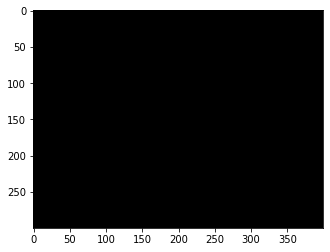

In [3]:
#width : height
res = [400, 300]
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)
plt.imshow(image)
plt.show()

**Note**: Our matrix looks like this: $$ [[[0, 0, 0], [0, 0, 0], [0, 0, 0], ...] $$
$$ ... $$
$$ [..., [0, 0, 0], [0, 0, 0], [0, 0, 0]]] $$

This is to future proof for when we want some color in our image. For now the 3 zeros in [0, 0, 0] corresponding to RGB, will have the same value, effectively converting to gray scale. From now on we consider our matrix to look like this:

$$ image = \begin{pmatrix}a_{11}&a_{12}&\cdots&a_{1n}\\a_{21}&a_{22}&\cdots&a_{2n}\\ \vdots&\vdots&\ddots&\vdots \\a_{m1}&a_{m2}&\cdots&a_{mn}\end{pmatrix} $$

### Pythagoras to the rescue

We now need a convenient way of changing pixel values so that we form a presivable image. We have the coordinates of the pixels and their values to our disposal, doesn't seem like much, but the hidden weapon here is measuring distances between points using the pythagorean theorem! And more precisely measuring distances between points and the origin. Lets now measure the distance between every pixel and the origin (0, 0) and increase its value depending on the length, pixels further away from the origin will have a bigger value.

$$ d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2} $$
since $(x_1, y_1) = (0, 0)$ we can simplify the distance formula to: 

$$ d = \sqrt{x_2^2 + y_2^2} $$

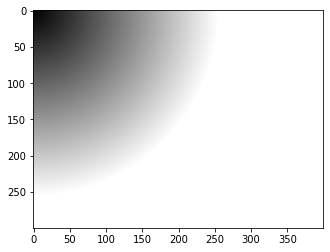

In [4]:
for y in range(len(image[::])):
    for x in range(len(image[y][::])):
        d = np.sqrt(x**2 + y**2)
        if d > 255:
            d = 255
        image[y][x] = np.array([d, d, d])

plt.imshow(image)
plt.show()

Here we encounter a small problem and should establish some rules. We have to limit our pixel values between 0 and 255, because we cannot display a whiter white than 255. Values bellow 0 are still just black. An even smarter idea would be to limit the pixel values between 0 and 1. Zero means 0% contribution the the channel and 0.87 means 87% contribution and so on. This will make things easier in the long run.

If we want to draw a circle easily we should normalize the coordinate system and move the origin to the middle of the window. The coordinate system will be limited between -0.5 and 0.5.

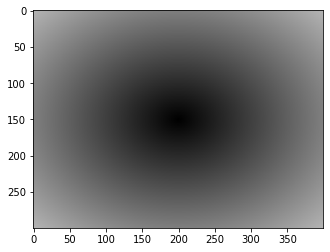

In [5]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)

for y in range(len(image[::])):
    y_norm = y / res[1] - 0.5
    for x in range(len(image[y][::])):
        x_norm = x / res[0] - 0.5 # -.5 <> .5
        d = np.sqrt(x_norm**2 + y_norm**2)
        if d > 1:
            d = 1
        image[y][x] = np.array([d, d, d]) * 255
        
plt.imshow(image)
plt.show()

### The circle

We are so close yet so far from a circle. A quick and durty way of drawing a circle follows these rules. If the distance from the origin to a point is less than the radius, that means that point is inside the circle and should be colored white. Points bigger than the radius are outside the circle and will be colored black. 

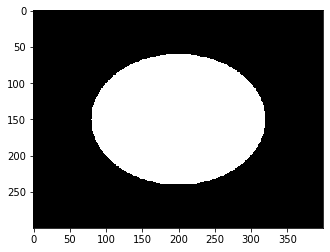

In [6]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)

for y in range(len(image[::])):
    y_norm = y / res[1] - 0.5
    for x in range(len(image[y][::])):
        x_norm = x / res[0] - 0.5
        d = np.sqrt(x_norm**2 + y_norm**2)
        if d <= 0.3:
            d = 1
        else:
            d = 0 
        image[y][x] = np.array([d, d, d]) * 255
        
plt.imshow(image)
plt.show()

Several problems occur: 
1. The circle is squished.
2. We see very jagged edges, which are ugly.

#### Smooth steps

Firstly the aspect ratio must be fixed, then we will need a very particular function. We want a nice transition between white and black, and eliminate discontinuities. The smooth step function is most easily explained with a picture.

![Diffraction](https://i.imgur.com/S07uIBX.png)

The distance p here is very important. If the distance p is small, that means that the point is close to the radius of the circle, so the color must be close to white, but if the distance is big, the color must be close to black. So asking the simple question, "what part of d is p" we get an easy solution. If p is a big part of d, say 90%, the color must be close to black and so on. The function should be able to step from black to white too, which simply reverses the logic a bit. 90% of d would mean a color close to white. Also we always get a number between 0 and 1, which nicely plays with what we have already.

In [7]:
def smoothstep(start, end, point):
    """
    Smooth transition between black and white in both directions.
    """
    if start >= point >= end:
        d = abs(start - end)
        output = (abs(point - start)) / d
    elif start <= point <= end:
        d = abs(start - end)
        output = (abs(point - start)) / d
    elif start > end:
        if point <= start:
            output = 1
        elif point >= end:
            output = 0
    elif start < end:
        if point < start:
            output = 0
        elif point > end:
            output = 1

    return output

Now using the smoothstep function we can package all kinds of neat shape functions. The circle function is pretty simple - it calculates all distances between every pixel and the center of the circle (by default the center is at the origin), then the smoothstep function uses these distances to determine which are inside the circle, which pixels are outside the circle, and which are in the blur section.

In [8]:
def circle(x_norm, y_norm, r, blur, p_x=0, p_y=0):
    """
    Draws circle with radius r and desired blur around it.
    """
    d = (x_norm - p_x)**2 + (y_norm - p_y)**2
    c = smoothstep(r, r - blur, d)
    return c

To fix the squishing, one of the axis must be either squished or stretched by the aspect ratio. The aspect ratio of an image is the height divided by the width.

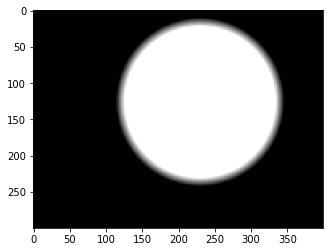

In [9]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)


def process_px(img):
    """
    Goes through every value in the img matrix.
    """
    for y in range(len(image[::])):
        y_norm = y / res[1] - 0.5
        for x in range(len(image[y][::])):
            x_norm = (x / res[0] - 0.5) / (res[1] / res[0])

            mask = circle(x_norm, y_norm, 0.15, 0.03, p_x=0.1, p_y=-0.08)

            image[y][x] = np.array([mask, mask, mask]) * 255


process_px(image)
plt.imshow(image)
plt.show()

### Renderers

In order to go to the next dimension some kind of renderer is needed. A renderer takes a 3D object and renders it on a 2D screen.
Most used renderers:

1. Rasterizer
2. Ray tracing
3. Ray marching

Ray marching seemed most appealing to me, it is not as slow as ray tracing, but offers similar results. But what is ray marching exactly? This approach mimics how in the real world rays of light from a light source bounce off objects and enter our eyes. In a way, the screen is our eye here, more precisely it is important to know what each pixel sees!

![Rays](https://i.imgur.com/wnn6rJb.png)

In the real world light travels from the light source to our eyes, but it also goes everywhere else, which would be very inefficient to simulate. It is much better to check only the rays that hit the camera... but finding which these rays are would be very expensive too. As a work around rather than tracing rays from the light sources, tracing from the camera through each pixel to the light is much much better.
Last thing to consider are collisions, the heart and soul of ray marching. This will be more easily explained with a simple animation I made.

### Raymarching

In [10]:
Video("ray_marching_smaller.mp4")

There are 2 simple steps to this process. In this example there is a ground plane and a sphere. The <span style="color:#ffcc00">yellow line</span> is a ray, and its starting point is the camera. Ray marching relays on finding the closest point of the scene, this ensures that the ray will not overshoot the sphere for example. After finding the distance to the closest point, the ray marches that distance to the scene, and then checks again for the nearest point, it also keeps track of the overall distance. Repeat these 2 steps until the distance to the closest point gets very small and count it as a hit.

#### The closest point

One question is still unanswered - How to find the closest point? The most basic way is to calculate the distance to every object in the scene and march forward the shortest distance. Checking the distance to the ground plane is simple - it is the y position of the camera minus the y position of the plane - this is because the camera is always perpendicular to the ground plane (in this example). The distance to the sphere is the distance to the sphere center minus the sphere radius.

![Dist](https://i.imgur.com/vzAwYVO.png)

The third additional dimension is depth or z for short, luckily the pythagorean theorem works in 3D too.

$$ d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2} $$

$$ d1 = y_{camera} - y_{plane} $$

The camera position will be 1 above the plane (so y = -1, because y is max at the bottom of the image) and at x = 0 and 0 depth. This is the ray origin!

In [11]:
ro = np.array([0, -1, 0])

A ray must pass through every pixel, so the ray direction is the x and y of the pixel and the screen being at 1 depth.

In [12]:
rd = np.array([x_norm, y_norm, 1])

A vector has a direction and a magnitude. The magnitude or the distance from the camera to the pixels at the bottom left for ex. is greater that the distance to the pixels right in front of the camera and this is going to mess up some calculations, since we want only the direction to have an effect. We need to normalize all vector directions, which means to "shorten" them to a unit vector, which has a magnitude of 1. Consider this example, if we have a vector which starts at (3, 4) and ends at (7, 7) its length (using the pythagorean theorem) is 5, in order to "shorten" it to a unit vector we need to divide its components by its length 5. And also the angle is preserved. Before normalization the angle was $ \tan \frac{3}{4} = 0.931 $ and after $ \tan \frac{\frac{3}{5}}{\frac{4}{5}} = \tan \frac{3}{4} = 0.931 $. For ease numpy will do the ray direction normalization.

In [13]:
rd = rd / np.linalg.norm(rd)

In [14]:
def get_dist(p):
    """
    Get shortest distance between the plane and the sphere
    """
    #                  x   y    z   r  
    sphere = np.array([0, -0.7, 3, 0.7])
    sphere_dist = np.sqrt((p[0] - sphere[0]) ** 2 + (p[1] - sphere[1]) ** 2 + (p[2] - sphere[2]) ** 2) - sphere[3]
    plane_dist = abs(p[1])

    d = min(sphere_dist, plane_dist)

    return d

In [15]:
min_dist = 0.01 #The min distance at which to stop stepping and count a hit
max_steps = 20 #If we encouter nothing for many steps, that means the ray missed the scene and went into the background.

def ray_march(ro, rd, min_dist = 0.01, max_steps = 20):
    """
    Step to the scene the shortest distance and keep track of the overall dist.
    """
    dO = 0
    for _ in range(100):
        p = ro + dO * rd
        dS = get_dist(p)
        dO += dS
        if dS < min_dist or dO > max_steps:
            break
    return dO

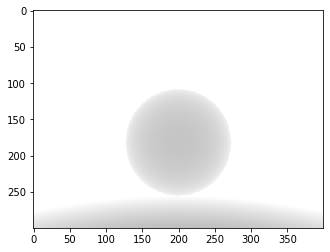

In [16]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)


def process_px(img):
    """
    Goes through every value in the img matrix.
    """
    for y in range(len(image[::])):
        y_norm = y / res[1] - 0.5
        for x in range(len(image[y][::])):
            x_norm = (x / res[0] - 0.5) / (res[1] / res[0])
            
            rd = np.array([x_norm, y_norm, 1])
            rd = rd / np.linalg.norm(rd)
            
            mask = ray_march(ro, rd)
            mask /= 3 #Divide by z of the sphere, because the min distance is already 1.
            
            if mask < 0:
                mask = 0
            if mask > 1:
                mask = 1

            image[y][x] = np.array([mask, mask, mask]) * 255


process_px(image)
plt.imshow(image)
plt.show()

### Let there be light

The result is the distance field. But something very major is missing, and that is a light source! Here things start to get a bit more complicated... Lets draw a simple lighting model.

![Lights](https://i.imgur.com/izVmOIb.png)

In this model, how bright a surface is depends on its orientation (the normal vector) and the angle to the light source. Maximum brightness is achieved when the normal vector and the light vector are the same, and a spot gets no light if the 2 vectors are perpendicular. Because only the angles matter both vectors must be normalized! The light vector (not dist!) is just the position of the point (which the light value is being calculated for) minus the light source position.
The normal vector is aways pointing perpendicularly to what it "sees" around it. Traditionally calculating the normal vector involves derivatives and slopes, but it is easier to approximate the slopes around the point using some simple logic.

#### Normal vectors
Lets approximate the slope of a 2D line. A picture will help a lot.

![2d_normal](https://i.imgur.com/dsTYAx6.png)

First we pick a point on the blue line. Then two more points are created at a very small distance (infinitesimal if possible), one to the left and the other below. The distance from these points to the slope is calculated using the find_dist function. These distances *a* and *b* are then the x and y components respectively of the normal vector. For a 3D plane it is much the same, there is just an additional point in front of the main point, and its distance to the plane is the z component of the normal vector.

#### Dot products

The dot product between the light vector and the normal vector tells us how much light a point receives. The traditional way of thinking about a dot product between two vectors is quite simple, multiply each component of the first with its corresponding one in the second and sum the products. The geometric interpretation is another way of thinking about dot products. In this sense it means to project one vector onto the other and taking the product of the length of the projection and the the length of the vector on which the projection is.

![dot_product_geometric](https://i.imgur.com/6rgV4p4.png)

So if the the vectors are the same, projecting one onto the other is the same as just taking the product of their lengths and the lengths are 1, because we normalized them. So the max value is 1, and the min is -1.

In [17]:
def get_light(p):
    light_pos = np.array([0.5, -3, 3])
    l = (light_pos - p) / np.linalg.norm(light_pos - p)
    n = get_normal(p)

    diff = np.dot(n, l) #diff is for diffused lighting, which describes the lighting model.

    return diff

In [18]:
def get_normal(p):
    d = get_dist(p) #When the point goes off in the background the distance to the scene is not 0, as it usually is.
                    #When the point is in the background the closest point to the scene is the ground plane.
    e = np.array([0.01, 0])

    n = np.array([d, d, d]) - np.array([(get_dist(p - [e[0], e[1], e[1]])), (get_dist(p - [e[1], e[0], e[1]])), (get_dist(p - [e[1], e[1], e[0]]))])

    return (n / np.linalg.norm(n))

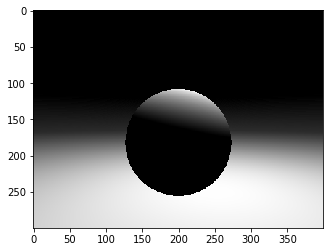

In [19]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)


def process_px(img):
    """
    Goes through every value in the img matrix.
    """
    for y in range(len(image[::])):
        y_norm = y / res[1] - 0.5
        for x in range(len(image[y][::])):
            x_norm = (x / res[0] - 0.5) / (res[1] / res[0])
            
            rd = np.array([x_norm, y_norm, 1])
            rd = rd / np.linalg.norm(rd)
            
            d = ray_march(ro, rd)
            p = ro + rd * d
            diff = get_light(p)
            mask = diff
            
            if mask < 0:
                mask = 0
            if mask > 1:
                mask = 1

            image[y][x] = np.array([mask, mask, mask]) * 255


process_px(image)
plt.imshow(image)
plt.show()

#### Shadow rays

Last thing to add are shadows. And here I am going to use a premade illustration.

![shadow_rays](https://i.imgur.com/UnieE7I.png)
Author = Henrik, 12 april 2008 (https://en.wikipedia.org/wiki/Ray_tracing_(graphics)#/media/File:Ray_trace_diagram.svg)

To check if a point is in shadow, we must ray march from that point to the light source. If the distance from ray marching to the light source is the same as calculating the distance with a pythagorean theorem, then the point is **not** in shadow. If the distance from the point to the light source by ray marching is smaller than the calculated distance, then the ray hit something on the way, thus it does not have "sight" of the light source and is in shadow.

In [20]:
def get_light(p):
    light_pos = np.array([0.5, -3, 2])
    l = (light_pos - p) / np.linalg.norm(light_pos - p)
    n = get_normal(p)

    diff = np.dot(n, l)
    d = ray_march(p + n*0.01*1.5, l) #The origin of the shadow ray must begin a little distance above the ground,
                                     #or else it will terminate because of the min_step.
    if d < (np.sqrt((light_pos[0] - p[0]) ** 2 + (light_pos[1] - p[1]) ** 2 + (light_pos[2] - p[2]) ** 2)):
        diff *= 0.25 #The shadow is not completelly black

    return diff

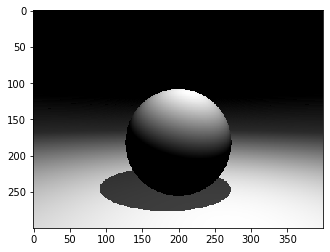

In [21]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)


def process_px(img):
    """
    Goes through every value in the img matrix.
    """
    for y in range(len(image[::])):
        y_norm = y / res[1] - 0.5
        for x in range(len(image[y][::])):
            x_norm = (x / res[0] - 0.5) / (res[1] / res[0])
            
            rd = np.array([x_norm, y_norm, 1])
            rd = rd / np.linalg.norm(rd)
            
            d = ray_march(ro, rd)
            p = ro + rd * d
            diff = get_light(p)
            mask = diff
            
            if mask < 0:
                mask = 0
            if mask > 1:
                mask = 1

            image[y][x] = np.array([mask, mask, mask]) * 255


process_px(image)
plt.imshow(image)
plt.show()

Et voila! What about a box? Here a 2D explanation will help. Just as the sphere we need a way to find the closest point to the box.

### The box

![dist_to_square](https://i.imgur.com/K9B8e6X.png)

Here the square is centered at the origin. The square has parts in all 4 quadrants of the coordinate system, but for now we will focus on the first one for reasons later explained. The first quadrant on its own splits in 3 parts (labeled 1, 2, 3). If the point P is in the first region its distance to the square is just the y coordinate of the point P minus Ry which is half the height of the square. If the point is in the second region (of the first quadrant) the distance to the square will be the x coordinate of the point P minus Rx which is half the width of the square. In case number 3, the closest point is the corner of the square. This distance is calculated using pythagoras. Here are the equations:

1)$$ d = Py - Ry $$

2)$$ d = Px - Rx $$

3)$$ d = \sqrt{(Px - Rx)^2 + (Py - Ry)^2} $$

But these are 3 whole equations for each quadrant, evaluating each one will cost a lot of ifs and time. In the best case scenario these must be generalized to only one equation and here is how. Both the first and the second equations appear in the third, more over when the point is the first region we want the first part of the third equation to be 0 and vise versa. If the point P is in the first region the first part of the third equation $(Px - Rx)^2$ will be negative, because where ever P is in the first region its x coordinate will always be to the left of Rx (Px < Rx if P is in first region). We must detect these negative values and make them 0. This is done with the built in ```max()``` function in python in such a manner:

```python
d = np.sqrt(max(Px - Rx, 0)**2 + max(Py - Ry, 0)**2)
```

Now the 4 quadrants must be generalized to a single one. It is easiest to "transfer" points to the first quadrant where both x, and y are positive. We want any point no matter the sign of x and y to go to positive y and positive x. The built in function ```abs()``` does the job perfectly. Example:

In [22]:
P = [-2, 3]
P_converted = [abs(P[0]), abs(P[1])]
P_converted

[2, 3]

In [23]:
P = [-27, -42]
P_converted = [abs(P[0]), abs(P[1])]
P_converted

[27, 42]

```python
d = np.sqrt(max(abs(Px) - Rx, 0)**2 + max(abs(Py) - Ry, 0)**2)
```

This is now a single expression that combines all regions and quadrants. It is easily expandable to 3D, the z (depth) component is added and the pythagorean theorem for distance between points in 3D is used. A small caveat is that the quadrant where x and y are both positive in **my** matrix is at the bottom right and not in the top right! Lets test it a bit.

In [24]:
a, b = 6, 4 #sides of the square
Rx, Ry = a / 2, b / 2
points = [[4, 0], [5, 3], [0, 0], [1, -1], [-3, -2], [-2, 2], [2, -6]]
distances = []

for p in points:
    d = np.sqrt(max(abs(p[0]) - Rx, 0)**2 + max(abs(p[1]) - Ry, 0)**2)
    distances.append(np.round(d, 2))

    
assert distances[0] == 1.0
assert distances[1] == 2.24
assert distances[2] == 0.0 # the function is not signed, distances inside the object are 0!
assert distances[3] == 0.0 # here too
assert distances[4] == 0.0
assert distances[5] == 0.0
assert distances[6] == 4.0

In [25]:
def dist_box(p, s):
    return np.sqrt(max(abs(p[0]) - s, 0)**2 + max(abs(p[1]) - s, 0)**2 + max(abs(p[2]) - s, 0)**2)

In [26]:
def get_dist(p):
    """
    Get shortest distance between the plane and the sphere
    """
    #                  x   y    z   r  
    sphere = np.array([0, -1.5, 3, 0.5])
    sphere_dist = np.sqrt((p[0] - sphere[0]) ** 2 + (p[1] - sphere[1]) ** 2 + (p[2] - sphere[2]) ** 2) - sphere[3]
    #                        x   y    z
    box_dist = dist_box(p - [0, -0.5, 3], 0.5) # p - [x, y, z] puts the box onto the plane and not under it.
    plane_dist = abs(p[1])

    d = min(box_dist, plane_dist, sphere_dist)

    return d

We add the box in the function that checks the distance to all objects in the scene.

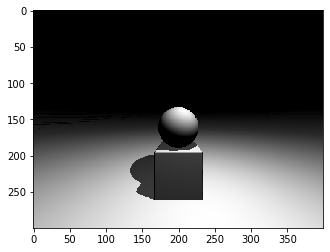

In [27]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)

ro = np.array([0, -1.7, 0.2])

def process_px(img):
    """
    Goes through every value in the img matrix.
    """
    for y in range(len(image[::])):
        y_norm = y / res[1] - 0.5
        for x in range(len(image[y][::])):
            x_norm = (x / res[0] - 0.5) / (res[1] / res[0])
            
            rd = np.array([x_norm, y_norm, 1 - 0.5])
            rd = rd / np.linalg.norm(rd)
            
            d = ray_march(ro, rd)
            p = ro + rd * d
            diff = get_light(p)
            mask = diff
            
            if mask < 0:
                mask = 0
            if mask > 1:
                mask = 1

            image[y][x] = np.array([mask, mask, mask]) * 255


process_px(image)
plt.imshow(image)
plt.show()

#### Rotation

This now looks nice, the shadow of the sphere is cast onto the plane and on the box too. The shadow of the box looks convincing too, but looking at it straight doesn't reveal the 3D nature of the composition too much. The camera (ro) could be moved and rotated, but there are more interesting maths if we try to rotate the box.
These shapes exist in a 3D coordinate system and as such it can be rotated and stretched. To rotate the box it is easier to multiply the x and z components that make the box with a 2D rotation matrix, it is 2D because I want the box to be rotated on the y axis.

30 degree rotation matrix (clockwise) $$ matrix = \begin{pmatrix}cos\frac{\pi}{6}&sin\frac{\pi}{6}&\\-sin\frac{\pi}{6}&cos\frac{\pi}{6}\end{pmatrix} $$

In [28]:
def get_dist(p):
    """
    Get shortest distance between the plane and the sphere
    """
    #                  x   y    z   r  
    sphere = np.array([0, -1.5, 3, 0.5])
    sphere_dist = np.sqrt((p[0] - sphere[0]) ** 2 + (p[1] - sphere[1]) ** 2 + (p[2] - sphere[2]) ** 2) - sphere[3]
    box_pos = p - [0, -0.5, 3]
    b = np.array([[0.866, 0.5], [-0.5, 0.866]]) 
    rotated = np.array([box_pos[0], box_pos[2]]).dot(b)
    box_pos[0], box_pos[2] = rotated[0], rotated[1]
    box_dist = dist_box(box_pos, 0.5)
    plane_dist = abs(p[1])

    d = min(box_dist, plane_dist, sphere_dist)

    return d

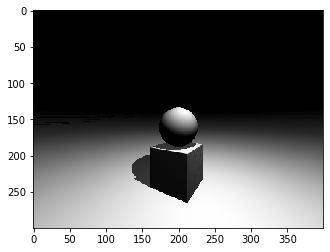

In [29]:
image = np.zeros(shape=[res[1], res[0], 3], dtype=np.uint8)

ro = np.array([0, -1.7, 0.1])

def process_px(img):
    """
    Goes through every value in the img matrix.
    """
    for y in range(len(image[::])):
        y_norm = y / res[1] - 0.5
        for x in range(len(image[y][::])):
            x_norm = (x / res[0] - 0.5) / (res[1] / res[0])
            
            rd = np.array([x_norm, y_norm, 1 - 0.5])
            rd = rd / np.linalg.norm(rd)
            
            d = ray_march(ro, rd)
            p = ro + rd * d
            diff = get_light(p)
            mask = diff
            
            if mask < 0:
                mask = 0
            if mask > 1:
                mask = 1

            image[y][x] = np.array([mask, mask, mask]) * 255


process_px(image)
plt.imshow(image)
plt.show()

## Comparison to ray tracing

The ray marcher takes ```~87,9``` second to render a sphere on top of a box with simple lighting, no colors and no reflections.

A python ray tracer by "jamesbowman" renders 3 balls with color and 5 iterations of reflections at the same resolution (400 by 300) in just *a fifth of a second*! That is a whopping speed up of **~440x**!!! Or way way more because of all the extra stuff... Here is his image, astonishing!

![jamesbowman_ray_tracer](https://i.imgur.com/As81zqY.png)

Why? Because this guy is smart and instead of looping through each pixel and call his functions 120 000 times (like me), he uses numpy arrays which are based on "C" and calculates everything simultaneously! There are also cool optimizations such as not rendering certain parts of the image. Amazing!

Can ray marching be optimized to be blazing fast in python? I am sure it can! I even have ideas, but simply lack the NumPy know how. And when it comes to more complicated shapes (such as 3D fractals) ray marching surely must be faster.

### The plot twist

BUT CAN RAY TRACING DO THIS?

In [30]:
def dist_sphere(p, s):
    p[0] = np.mod(p[0], 1) - 0.7
    p[2] = np.mod(p[2], 1) - 0.7
    return (np.sqrt(p[0]**2 + p[1]**2 + p[2]**2) - s)

In [31]:
def get_dist(p):
    """
    Get shortest distance between the plane and the sphere
    """
    plane_dist = abs(p[1])
    sphere_dist = dist_sphere(p - [0, -0.6, 0], 0.3)

    d = min(plane_dist, sphere_dist)

    return d

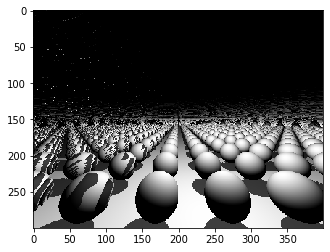

In [32]:
def process_px(img):
    """
    Goes through every value in the img matrix.
    """
    for y in range(len(image[::])):
        y_norm = y / res[1] - 0.5
        for x in range(len(image[y][::])):
            x_norm = (x / res[0] - 0.5) / (res[1] / res[0])
            
            rd = np.array([x_norm, y_norm, 1 - 0.5])
            rd = rd / np.linalg.norm(rd)
            
            d = ray_march(ro, rd)
            p = ro + rd * d
            diff = get_light(p)
            mask = diff
            
            if mask < 0:
                mask = 0
            if mask > 1:
                mask = 1

            image[y][x] = np.array([mask, mask, mask]) * 255


process_px(image)
plt.imshow(image)
plt.show()

This is the strong suite of ray marching - bending space. At no additional cost (finished in ~68 secs) ray marching can render millions of objects! How does it work? I have little to no idea, this is why I left it until the end. It has something to do with the modulo devision of the x and z axis, but that is it. Also something is obviously wrong with the spheres on the left and in the background, which I have not figured out yet, but should be easily fixable.

## Conclusion

Taking 2D primitives to the 3D space and then back on a 2D screen is a very mathematically driven process. Ray marching as a renderer offers great performance, especially for repeating objects and comparable visual result to more complicated renderers. It is very intuitive and has a lot of potential.

Thank you for reading! :)

## References

**Inspiration**: 

Marble Marcher - https://www.youtube.com/watch?v=9U0XVdvQwAI

SDFs - https://www.youtube.com/watch?time_continue=1&v=PMltMdi1Wzg

Microscopy - https://www.youtube.com/watch?v=V8JXPqDWFcM, https://www.youtube.com/watch?v=sTa-Hn_eisw&t=1110s

**Learning materials**:

Ray Marching for Dummies - https://www.youtube.com/watch?v=PGtv-dBi2wE

Ray Marching Simple Shapes - https://www.youtube.com/watch?v=Ff0jJyyiVyw&t=47s

Deriving the SDF of a Box - https://www.youtube.com/watch?v=62-pRVZuS5c

Matrix multiplication as composition - https://www.youtube.com/watch?v=XkY2DOUCWMU

Making a heart with mathematics - https://www.youtube.com/watch?v=aNR4n0i2ZlM

Shader Deconstruction - https://www.youtube.com/watch?v=Cfe5UQ-1L9Q&t=827s

Khan Academy - https://www.khanacademy.org/

Inigo Quilez - https://iquilezles.org/www/index.htm

Distance Estimated 3D Fractals - http://blog.hvidtfeldts.net/index.php/2011/06/distance-estimated-3d-fractals-part-i/

GeoGebra 3D - very easy to visualize stuff.

Illustrations and animations done in PowerPoint and Paint.

**Citations**:

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55 (publisher link)

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37 (publisher link)

Python ray tracer by "jamesbowman" - https://github.com/jamesbowman/raytrace/blob/master/rt3.py
and his page on the topic - https://excamera.com/sphinx/article-ray.html